# ASSIGNMENT 2 - Albertini, Lafronza, Ranieri

### References 

- https://github.com/lucabenedetto/2019-ai-for-security

- https://github.com/oreilly-mlsec/book-resources

- https://scikit-learn.org/stable/index.html

- Mark Carman's slides

- Chio, C. and Freeman, D. (2018). Machine Learning and Security. O'Reilly.

### Index
- 1. Exploring and preparing data
- 2. Classification
    - 2.1. Decision Tree
    - 2.2. Random Forest
    - 2.3. Multi-layer Perceptron
    - 2.4. C-Support Vector Classification
         - 2.4.1. Linear
         - 2.4.2. Non-linear
- 3. Cross-validation
    - 3.1. Decision Tree
    - 3.2. Random Forest
    - 3.3. Multi-layer Perceptron
    - 3.4. C-Support Vector Classification
- 4. Results
- 5. Clustering
    - 5.1. Training the clustering algorithm
         - 5.1.1. Evaluating the cluster algorithm
    - 5.2. Hierarchical Clustering
         - 5.2.1. Evaluating the clustering algorithm
- 6. Mapping features to categories and re-classification using best hyperparameters combination
    - 6.1. Mapping from features to categories
    - 6.2. New test of the classifiers
         - 6.2.1. Decision Tree
         - 6.2.2. Random Forest
         - 6.2.3. Multi-layer Perceptron
         - 6.2.4. C-Support Vector Classification
    - 6.3. Merging columns before training
         - 6.3.1. Decision Tree
         - 6.3.2. Random Forest
         - 6.3.3. Multi-layer Perceptron
         - 6.3.4. C-Support Vector Classification
- 7. Final Results

## 1. Exploring and preparing data

The first action we are going to perform is the import of some useful libraries that we generally use in order to analyze dataframes, those are pandas, numpy, time and matplotlib. After doing that the second important action in order to start working is to import the dataframe from our MalwareAnalysis folder.

In [1]:
import pandas as pd
import numpy as np 
import time 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../ASSIGNMENT/data/AndroidMalware/drebin-215-dataset-5560malware-9476-benign.csv')

C:\Users\Utente\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


After the import of the dataframe, in order to decide how to start working, we have to have a look at the dataframe. The most important things that we want to discover are the shape of the dataframe, how columns, rows and data look like (taking a sample or analyzing the head of the dataframe) and inspecting the type of the columns.

<b> NB. Some commands that are marked with an # have been executed during our testing but, in order to save space and to not load the machine too much, we marked them as text. In this way the execution is possible only if it is necessary. </b>

In [3]:
# df.head(5)

In [4]:
# df.shape

In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15036 entries, 0 to 15035
Data columns (total 216 columns):
transact                                           int64
onServiceConnected                                 int64
bindService                                        int64
attachInterface                                    int64
ServiceConnection                                  int64
android.os.Binder                                  int64
SEND_SMS                                           int64
Ljava.lang.Class.getCanonicalName                  int64
Ljava.lang.Class.getMethods                        int64
Ljava.lang.Class.cast                              int64
Ljava.net.URLDecoder                               int64
android.content.pm.Signature                       int64
android.telephony.SmsManager                       int64
READ_PHONE_STATE                                   int64
getBinder                                          int64
ClassLoader                        

With .info we noticed that every column contains integer values, except for two, "classes" and "TelephonyManager.getSimCountryIso". We imagined that class is our label column so we decided to in-depth analyze the other column. The first thing we did is to check which unique values are contained into the column.

In [6]:
set(df['TelephonyManager.getSimCountryIso'])

{0, '0', 1, '1', '?'}

After discovering that it is a "binary" column we noticed that there was also a "?" that could have created some problems during the analysis and we wanted to drop it. The problem is that dropping the cells containing the "?" would create a lot of troubles because it will permanently modify the shape of the column, losing some observation fields. So, in order to solve this problem we decided to dummy this column and then drop the dummy column that contained the "?". In this way we can perform our analysis on dummy columns without losing values or modifying our original one. To do this operation we initially modified the type of the column as string, because as we see before there were some duplicates because one value was in form of an integer and one in form of a string.

In [7]:
df['TelephonyManager.getSimCountryIso'] = df['TelephonyManager.getSimCountryIso'].astype('str')

Here there is the check that shows that now that we have changed the type of the column there are no longer duplicates.

In [8]:
set(df['TelephonyManager.getSimCountryIso'])

{'0', '1', '?'}

As there are a lot of columns into the dataframe we wanted to discover the position of our column.

In [9]:
df.columns.get_loc('TelephonyManager.getSimCountryIso')

92

Another inspection that is useful is to check the unique values of the other object column into the dataframe, the "class" column.

In [10]:
set(df['class'])

{'B', 'S'}

In [11]:
# for column in df.columns:
    # print(set(df[column]))

In [12]:
# for column in df.columns:
#     print(df.groupby([column,'class']).size().reset_index().sort_values(0,ascending=False).rename(columns={0:'count'}))

As we can see with the checks we have done each row represent a vector, each feature is represented with 1 if is present in the observation and with 0 if not. Now we will do the operation described above in order to remove the "?" without affecting the observation. The first thing is to create a new dataframe with the dummies of the desired column.

In [13]:
df_one_hot = pd.get_dummies(df,columns=['TelephonyManager.getSimCountryIso'])

In [14]:
# df_one_hot.info(verbose=True)

Then we are going to drop the dummy column of "?". We are doing this combined to another important operation necessary in order to analyze this dataframe, the split operation. In fact in NetworkAnalysis we had two different dataframes, one for training and one for testing. In this case we have only one dataframe and we have to split it. We do this using the sklearn "split" that gives us the possibility to choose the % of data we want to assign to the test variables. For this analysis we decided that the train variables will contain the 70% of the data and the test the 30%.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_one_hot.drop(['TelephonyManager.getSimCountryIso_?', 'class'], axis=1), 
    df_one_hot['class'], 
    test_size=0.3
)

Here there is the check for the shape of the variables that we have created. The sum of the count of the y variables must be equal to the number of rows of the X variables.

In [16]:
print(X_train.shape)
print(X_test.shape)

(10525, 216)
(4511, 216)


In [17]:
print(y_train.value_counts())
print(y_test.value_counts())

B    6635
S    3890
Name: class, dtype: int64
B    2841
S    1670
Name: class, dtype: int64


## 2. Classification

To start the classification we have to import the different classifiers from sklearn library.

In [18]:
# Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
# Cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# Metrics
from sklearn.metrics import (accuracy_score, recall_score, precision_score, confusion_matrix, classification_report, 
                            balanced_accuracy_score, f1_score)

<b> NB. While trying every classifier we will also check the time it requires to train and to predict. </b>

<b> NB. The operations of training and testing on the different classifiers are similar so, in order to not be repetitive, we are going to describe in depth the operations done only with the first classifiers. For the others we will declare what we are doing and only describe if there are some important changes. </b>

### 2.1. Decision Tree

The first classifier we are going to train is the DecisionTree. In this cell we are performing both the training, on X_train and y_train, and the prediction. As specified before we are storing the training and the prediction time of the classifier in order to print it with the results, because it is important to evaluate the efficiency of a classifier.

In [19]:
# start the timer
start_time = time.time()
#print(time.time())

clf_DT = DecisionTreeClassifier(criterion='gini',splitter='best').fit(X_train, y_train)

# stop the timer and print the result
elapsed_training_time_DT = time.time() - start_time
print("Elapsed time to fit the model: %.2f seconds" % elapsed_training_time_DT,'\n')

# start the timer
start_time = time.time()

y_pred_DT = clf_DT.predict(X_test)

# stop the timer and print the result
elapsed_prediction_time_DT = time.time() - start_time
print("Elapsed time to make the predictions: %.2f seconds" % elapsed_prediction_time_DT,'\n')

Elapsed time to fit the model: 0.29 seconds 

Elapsed time to make the predictions: 0.01 seconds 



Here we are doing an operation that we will do on every classifier, storing important calculations done on the predicted variable, in order to show them later. The operations that we are performing (that will be the same for every classifier we will test) are:
1. Accuracy Score
2. Classification Report
3. Balanced Accuracy Score
4. Confusion matrix (done utilizing the true values of y_test, meaning it is perfectly correct)
5. Confusion matrix (predicted)

In [20]:
accuracy_score_DT = accuracy_score(y_test,y_pred_DT)

classification_report_DT = classification_report(y_test,y_pred_DT,digits=5)

balanced_accuracy_score_DT = balanced_accuracy_score(y_test,y_pred_DT)

confusion_matrix_true_DT = confusion_matrix(y_test, y_test)   

confusion_matrix_pred_DT = confusion_matrix(y_test,y_pred_DT)

Here there is the printing of the variables we have created for this classifier.

In [21]:
print('elapsed time for training:',elapsed_training_time_DT,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_DT,'\n')

print('classification_report: \n', classification_report_DT,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_DT,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_DT,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_DT)

elapsed time for training: 0.2902193069458008 

elapsed time to make predictions: 0.01096653938293457 

classification_report: 
               precision    recall  f1-score   support

           B    0.97983   0.97466   0.97724      2841
           S    0.95727   0.96587   0.96155      1670

    accuracy                        0.97140      4511
   macro avg    0.96855   0.97026   0.96939      4511
weighted avg    0.97148   0.97140   0.97143      4511
 

balanced_accuracy_score: 0.9702625372275513 

confusion_matrix-true value: 
 [[2841    0]
 [   0 1670]] 

confusion_matrix-pred value: 
 [[2769   72]
 [  57 1613]]


### 2.2. Random Forest

Training and Prediction:

In [22]:
# start the timer
start_time = time.time()
#print(time.time())

clf_RF = RandomForestClassifier(criterion='gini',verbose=1,warm_start=True,).fit(X_train, y_train)

# stop the timer and print the result
elapsed_training_time_RF = time.time() - start_time
print("Elapsed time to fit the model: %.2f seconds" % elapsed_training_time_RF,'\n')

# start the timer
start_time = time.time()

y_pred_RF = clf_RF.predict(X_test)

# stop the timer and print the result
elapsed_prediction_time_RF = time.time() - start_time
print("Elapsed time to make the predictions: %.2f seconds" % elapsed_prediction_time_RF,'\n')

C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Elapsed time to fit the model: 0.21 seconds 

Elapsed time to make the predictions: 0.02 seconds 



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Creation of variables and print:

In [23]:
accuracy_score_RF = accuracy_score(y_test,y_pred_RF)

classification_report_RF = classification_report(y_test,y_pred_RF,digits=5)

balanced_accuracy_score_RF = balanced_accuracy_score(y_test,y_pred_RF)

confusion_matrix_true_RF = confusion_matrix(y_test, y_test)   

confusion_matrix_pred_RF = confusion_matrix(y_test,y_pred_RF)

In [24]:
print('elapsed time for training:',elapsed_training_time_RF,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_RF,'\n')

print('classification_report: \n', classification_report_RF,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_RF,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_RF,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_RF)

elapsed time for training: 0.20844125747680664 

elapsed time to make predictions: 0.021941184997558594 

classification_report: 
               precision    recall  f1-score   support

           B    0.97644   0.99190   0.98411      2841
           S    0.98585   0.95928   0.97238      1670

    accuracy                        0.97983      4511
   macro avg    0.98114   0.97559   0.97825      4511
weighted avg    0.97992   0.97983   0.97977      4511
 

balanced_accuracy_score: 0.9755928480947292 

confusion_matrix-true value: 
 [[2841    0]
 [   0 1670]] 

confusion_matrix-pred value: 
 [[2818   23]
 [  68 1602]]


### 2.3. Multi-Layer Perceptron

Training and Prediction:

In [25]:
# start the timer
start_time = time.time()
#print(time.time())

# define the classifier
clf_MLP = MLPClassifier(hidden_layer_sizes=(200, ), activation='relu', solver='sgd',learning_rate='adaptive',verbose=True)

# train the classifier
clf_MLP.fit(X_train, y_train)

# stop the timer and print the result
elapsed_training_time_MLP = time.time() - start_time
print("Elapsed time to fit the model: %.2f seconds" % elapsed_training_time_MLP,'\n')

# start the timer
start_time = time.time()

# perform the prediction
y_pred_MLP = clf_MLP.predict(X_test)

# stop the timer and print the result
elapsed_prediction_time_MLP = time.time() - start_time
print("Elapsed time to make the prediction: %.2f seconds" % elapsed_prediction_time_MLP,'\n')

Iteration 1, loss = 0.64215050
Iteration 2, loss = 0.50113567
Iteration 3, loss = 0.42553301
Iteration 4, loss = 0.37140219
Iteration 5, loss = 0.33156483
Iteration 6, loss = 0.30177455
Iteration 7, loss = 0.27885949
Iteration 8, loss = 0.26072686
Iteration 9, loss = 0.24593657
Iteration 10, loss = 0.23361154
Iteration 11, loss = 0.22305959
Iteration 12, loss = 0.21398230
Iteration 13, loss = 0.20595535
Iteration 14, loss = 0.19884208
Iteration 15, loss = 0.19248830
Iteration 16, loss = 0.18672015
Iteration 17, loss = 0.18146690
Iteration 18, loss = 0.17666502
Iteration 19, loss = 0.17226329
Iteration 20, loss = 0.16816149
Iteration 21, loss = 0.16437667
Iteration 22, loss = 0.16085797
Iteration 23, loss = 0.15759383
Iteration 24, loss = 0.15449219
Iteration 25, loss = 0.15158508
Iteration 26, loss = 0.14887740
Iteration 27, loss = 0.14630773
Iteration 28, loss = 0.14384995
Iteration 29, loss = 0.14156493
Iteration 30, loss = 0.13936850
Iteration 31, loss = 0.13726745
Iteration 32, los

C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Creation of variables and print:

In [26]:
accuracy_score_MLP = accuracy_score(y_test,y_pred_MLP)

classification_report_MLP = classification_report(y_test,y_pred_MLP,digits=5)

balanced_accuracy_score_MLP = balanced_accuracy_score(y_test,y_pred_MLP)

confusion_matrix_true_MLP = confusion_matrix(y_test, y_test)   

confusion_matrix_pred_MLP = confusion_matrix(y_test,y_pred_MLP)

In [27]:
print('elapsed time for training:',elapsed_training_time_MLP,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_MLP,'\n') 

print('classification_report: \n', classification_report_MLP,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_MLP,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_MLP,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_MLP)

elapsed time for training: 43.71689057350159 

elapsed time to make predictions: 0.05086374282836914 

classification_report: 
               precision    recall  f1-score   support

           B    0.97385   0.98310   0.97846      2841
           S    0.97079   0.95509   0.96287      1670

    accuracy                        0.97273      4511
   macro avg    0.97232   0.96910   0.97066      4511
weighted avg    0.97271   0.97273   0.97269      4511
 

balanced_accuracy_score: 0.9690971805069903 

confusion_matrix-true value: 
 [[2841    0]
 [   0 1670]] 

confusion_matrix-pred value: 
 [[2793   48]
 [  75 1595]]


### 2.4. C-Support Vector Classification

<b>Support vector machines (SVMs)</b> are a set of supervised learning methods used for classification, regression and outliers detection.

Basic *support vector machine* (SVM) is a linear classifier that finds hyperplane in vector space that separates two classes as does *logist regression* (LR). 

The difference between LR and SVMs is the loss function:

- LR uses *log-likelihood* which penalizes points proportionally to probability of incorrect prediction including those on *correct side of hyperplane*
- SVM uses <b>*hinge loss*</b> which penalizes points on wrong side of hyperplane or very close to it on correct side

The power of SVMs comes from <b>*kernel trick*</b>, that is a mathematical transformation that converts linear decision buondary into non-linear one. 


##### The advantages of support vector machines are:

- Effective in high dimensional spaces.

- Still effective in cases where number of dimensions is greater than the number of samples.

- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

- Versatile: different Kernel functions can be specified for the decision function. 

##### The disadvantages of support vector machines include:

- If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.

- SVMs do not directly provide probability estimates.

#### 2.4.1. Linear

Training and Prediction:

In [28]:
# start the timer
start_time = time.time()
#print(time.time())

# define the classifier
clf_LinearSVC = LinearSVC(verbose=1,penalty='l2',loss='hinge')

# train the classifier
clf_LinearSVC.fit(X_train, y_train)

# stop the timer and print the result
elapsed_training_time_LinearSVC = time.time() - start_time
print("Elapsed time to fit the model: %.2f seconds" % elapsed_training_time_LinearSVC,'\n')

# start the timer
start_time = time.time()

# perform the prediction
y_pred_LinearSVC = clf_LinearSVC.predict(X_test)

# stop the timer and print the result
elapsed_prediction_time_LinearSVC = time.time() - start_time
print("Elapsed time to make the prediction: %.2f seconds" % elapsed_prediction_time_LinearSVC,'\n')

[LibLinear]Elapsed time to fit the model: 0.42 seconds 

Elapsed time to make the prediction: 0.01 seconds 



C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Creation of variables and print:

In [29]:
accuracy_score_LinearSVC = accuracy_score(y_test,y_pred_LinearSVC)

classification_report_LinearSVC = classification_report(y_test,y_pred_LinearSVC,digits=5)

balanced_accuracy_score_LinearSVC = balanced_accuracy_score(y_test,y_pred_LinearSVC)

confusion_matrix_true_LinearSVC = confusion_matrix(y_test, y_test)   

confusion_matrix_pred_LinearSVC = confusion_matrix(y_test,y_pred_LinearSVC)

In [30]:
print('elapsed time for training:',elapsed_training_time_LinearSVC,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_LinearSVC,'\n') 

print('classification_report: \n', classification_report_LinearSVC,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_LinearSVC,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_LinearSVC,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_LinearSVC)

elapsed time for training: 0.41588640213012695 

elapsed time to make predictions: 0.011967658996582031 

classification_report: 
               precision    recall  f1-score   support

           B    0.97938   0.98627   0.98281      2841
           S    0.97636   0.96467   0.97048      1670

    accuracy                        0.97828      4511
   macro avg    0.97787   0.97547   0.97665      4511
weighted avg    0.97826   0.97828   0.97825      4511
 

balanced_accuracy_score: 0.9754715489822888 

confusion_matrix-true value: 
 [[2841    0]
 [   0 1670]] 

confusion_matrix-pred value: 
 [[2802   39]
 [  59 1611]]


#### 2.4.2. Non linear

kernel != linear

Training and Prediction:

In [31]:
# start the timer
start_time = time.time()
#print(time.time())

# define the classifier
clf_SVC = SVC(verbose=1,kernel='rbf',gamma='scale',shrinking=True,decision_function_shape='ovr')

# train the classifier
clf_SVC.fit(X_train, y_train)

# stop the timer and print the result
elapsed_training_time_SVC = time.time() - start_time
print("Elapsed time to fit the model: %.2f seconds" % elapsed_training_time_SVC,'\n')

# start the timer
start_time = time.time()

# perform the prediction
y_pred_SVC = clf_SVC.predict(X_test)

# stop the timer and print the result
elapsed_prediction_time_SVC = time.time() - start_time
print("Elapsed time to make the prediction: %.2f seconds" % elapsed_prediction_time_SVC,'\n')

[LibSVM]Elapsed time to fit the model: 5.13 seconds 

Elapsed time to make the prediction: 1.66 seconds 



Creation of variables and print:

In [32]:
accuracy_score_SVC = accuracy_score(y_test,y_pred_SVC)

classification_report_SVC = classification_report(y_test,y_pred_SVC,digits=5)

balanced_accuracy_score_SVC = balanced_accuracy_score(y_test,y_pred_SVC)

confusion_matrix_true_SVC = confusion_matrix(y_test, y_test)   

confusion_matrix_pred_SVC = confusion_matrix(y_test,y_pred_SVC)

In [33]:
print('elapsed time for training:',elapsed_training_time_SVC,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_SVC,'\n') 

print('classification_report: \n', classification_report_SVC,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_SVC,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_SVC,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_SVC)

elapsed time for training: 5.130272388458252 

elapsed time to make predictions: 1.658562421798706 

classification_report: 
               precision    recall  f1-score   support

           B    0.97813   0.99155   0.98479      2841
           S    0.98529   0.96228   0.97364      1670

    accuracy                        0.98071      4511
   macro avg    0.98171   0.97691   0.97922      4511
weighted avg    0.98078   0.98071   0.98067      4511
 

balanced_accuracy_score: 0.976913859714573 

confusion_matrix-true value: 
 [[2841    0]
 [   0 1670]] 

confusion_matrix-pred value: 
 [[2817   24]
 [  63 1607]]


## 3. Cross-Validation

Now we will use GridSearchCV to conduct an exhaustive search over specified parameter values for an estimator.
We will look the result and then choose another set of hyperparameters trying to improve our classifiers' performances.

### 3.1. DecisionTree

With this classifier we are going to store into a dictionary called "param_grid" a list of values for all the attributes of the model, in this way we can search for the best parameter for the classifier and use that when we are going to perform the prediction. This should give us the best result possible for all the parameters given. We are also printing which are the best parameter and the score of the classification with these parameters.

In [34]:
start_time = time.time()

classifier = DecisionTreeClassifier()

pipe = Pipeline(steps=[('clf', classifier)])

param_grid = {
    'clf__max_leaf_nodes': [100,300,500,700,None],
    'clf__max_depth': [100, 300, 500,None],
    'clf__splitter' : ['best','random'],
    'clf__criterion' : ['gini','entropy']
}

searchDT = GridSearchCV(pipe, param_grid, iid=False, cv=5, verbose=True, return_train_score=True)
searchDT.fit(X_train, y_train)

trainedDT = searchDT.best_estimator_.get_params()['clf']

elapsed_training_searching_time_trainedDT = time.time() - start_time
print("Elapsed time to fit the model and compare the hyperparameters: %.2f seconds" % elapsed_training_searching_time_trainedDT,'\n')

best_params_DT = searchDT.best_params_
best_score_DT = searchDT.best_score_

print('searchDT best combination of these hyperparameters is:',best_params_DT,'\n')
print('searchDT best score for these hyperparameters is:',best_score_DT,'\n')

start_time = time.time()

y_pred_trainedDT = trainedDT.predict(X_test)

elapsed_prediction_time_trainedDT = time.time() - start_time
print("Elapsed time to make preditictions: %.2f seconds" % elapsed_prediction_time_trainedDT,'\n')

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.9min finished


Elapsed time to fit the model and compare the hyperparameters: 114.07 seconds 

searchDT best combination of these hyperparameters is: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_leaf_nodes': 500, 'clf__splitter': 'best'} 

searchDT best score for these hyperparameters is: 0.977957244655582 

Elapsed time to make preditictions: 0.01 seconds 



Creation of variables and print:

In [35]:
accuracy_score_trainedDT = accuracy_score(y_test,y_pred_trainedDT)

classification_report_trainedDT = classification_report(y_test,y_pred_trainedDT,digits=5)

balanced_accuracy_score_trainedDT = balanced_accuracy_score(y_test,y_pred_trainedDT)

confusion_matrix_true_trainedDT = confusion_matrix(y_test, y_test)   

confusion_matrix_pred_trainedDT = confusion_matrix(y_test,y_pred_trainedDT)

In [36]:
print('elapsed time for training:',elapsed_training_searching_time_trainedDT,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_trainedDT,'\n') 

print('classification_report: \n', classification_report_trainedDT,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_trainedDT,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_trainedDT,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_trainedDT)

elapsed time for training: 114.07212162017822 

elapsed time to make predictions: 0.01096963882446289 

classification_report: 
               precision    recall  f1-score   support

           B    0.98121   0.97395   0.97757      2841
           S    0.95624   0.96826   0.96221      1670

    accuracy                        0.97185      4511
   macro avg    0.96872   0.97111   0.96989      4511
weighted avg    0.97196   0.97185   0.97188      4511
 

balanced_accuracy_score: 0.9711081532816099 

confusion_matrix-true value: 
 [[2841    0]
 [   0 1670]] 

confusion_matrix-pred value: 
 [[2767   74]
 [  53 1617]]


Here we are looking for the first 40 features (columns) of the dataframe, the order is based on their importance for the classifier. We are also creating a new variable (as an array) that only contains these columns.

In [37]:
sort_importances = np.argsort(trainedDT.feature_importances_)
top_40_features_DT = sort_importances[0:40]

In [38]:
top_40_features_DT

array([107, 135,  67, 137,  65, 141, 142, 143, 146, 134, 110, 156, 157,
       158,  49, 159, 160, 161, 162, 155, 163,  71, 131, 111, 106, 113,
       104, 102, 114,  97, 118,  74, 119,  90,  89,  88,  83, 125, 126,
        78], dtype=int64)

In [39]:
X_train.columns[top_40_features_DT]

Index(['MASTER_CLEAR', 'WRITE_SOCIAL_STREAM', 'READ_PROFILE', 'REBOOT',
       'BIND_REMOTEVIEWS', 'MessengerService', 'BIND_DEVICE_ADMIN',
       'WRITE_GSERVICES', 'SET_ALARM', 'android.intent.action.SENDTO',
       'WRITE_CALL_LOG', 'android.intent.action.SCREEN_ON',
       'Context.bindService', 'RECEIVE_MMS', 'WRITE_SYNC_SETTINGS',
       'SET_TIME_ZONE', 'android.intent.action.BATTERY_OKAY',
       'CONTROL_LOCATION_UPDATES', 'BROADCAST_WAP_PUSH', 'Process.start',
       'BIND_ACCESSIBILITY_SERVICE', 'READ_SYNC_STATS', 'BATTERY_STATS',
       'DELETE_PACKAGES', 'android.intent.action.PACKAGE_DATA_CLEARED',
       'GLOBAL_SEARCH', 'CHANGE_WIFI_MULTICAST_STATE', 'SUBSCRIBED_FEEDS_READ',
       'DELETE_CACHE_FILES', 'sendDataMessage', 'REORDER_TASKS',
       'android.intent.action.TIMEZONE_CHANGED', 'WRITE_PROFILE',
       'SUBSCRIBED_FEEDS_WRITE', 'READ_CALL_LOG', 'READ_CALENDAR',
       'PathClassLoader', 'PROCESS_OUTGOING_CALLS', 'CALL_PRIVILEGED',
       'Ljava.lang.Class.getPac

### 3.2. RandomForest

<b> WARNING: Requires around 14 mins to train and predict </b>

Training and Prediction searching for best hyperparameters:

In [40]:
start_time = time.time()

classifier = RandomForestClassifier(verbose=False)

pipe = Pipeline(steps=[('clf', classifier)])

param_grid = {
    'clf__n_estimators': [100,200,400],
    'clf__max_depth': [85,170,340,None],
    'clf__max_leaf_nodes' : [1000,None],
    'clf__criterion' : ['gini','entropy']
}

searchRF = GridSearchCV(pipe, param_grid, iid=False, cv=5, verbose=True, return_train_score=True)
searchRF.fit(X_train, y_train)

trainedRF = searchRF.best_estimator_.get_params()['clf']

elapsed_training_searching_time_trainedRF = time.time() - start_time
print("Elapsed time to fit the model and compare the hyperparameters: %.2f seconds" % elapsed_training_searching_time_trainedRF,'\n')

best_params_RF = searchRF.best_params_
best_score_RF = searchRF.best_score_

print('searchRF best combination of these hyperparameters is:',best_params_RF,'\n')
print('searchRF best score for these hyperparameters is:',best_score_RF,'\n')

start_time = time.time()

y_pred_trainedRF = trainedRF.predict(X_test)

elapsed_prediction_time_trainedRF = time.time() - start_time
print("Elapsed time to make preditictions: %.2f seconds" % elapsed_prediction_time_trainedRF,'\n')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 18.2min finished


Elapsed time to fit the model and compare the hyperparameters: 1092.44 seconds 

searchRF best combination of these hyperparameters is: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_leaf_nodes': None, 'clf__n_estimators': 100} 

searchRF best score for these hyperparameters is: 0.9879334916864607 

Elapsed time to make preditictions: 0.16 seconds 



Creation of variables and print:

In [41]:
accuracy_score_trainedRF = accuracy_score(y_test,y_pred_trainedRF)

classification_report_trainedRF = classification_report(y_test,y_pred_trainedRF,digits=5)

balanced_accuracy_score_trainedRF = balanced_accuracy_score(y_test,y_pred_trainedRF)

confusion_matrix_true_trainedRF = confusion_matrix(y_test, y_test)   

confusion_matrix_pred_trainedRF = confusion_matrix(y_test,y_pred_trainedRF)

In [42]:
print('elapsed time for training:',elapsed_training_searching_time_trainedRF,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_trainedRF,'\n')

print('classification_report: \n', classification_report_trainedRF,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_trainedRF,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_trainedRF,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_trainedRF)

elapsed time for training: 1092.4386422634125 

elapsed time to make predictions: 0.15857672691345215 

classification_report: 
               precision    recall  f1-score   support

           B    0.98193   0.99472   0.98828      2841
           S    0.99081   0.96886   0.97972      1670

    accuracy                        0.98515      4511
   macro avg    0.98637   0.98179   0.98400      4511
weighted avg    0.98522   0.98515   0.98511      4511
 

balanced_accuracy_score: 0.9817912222018477 

confusion_matrix-true value: 
 [[2841    0]
 [   0 1670]] 

confusion_matrix-pred value: 
 [[2826   15]
 [  52 1618]]


Searching for the most important features:

In [43]:
sort_importances = np.argsort(trainedRF.feature_importances_)
top_40_features_RF = sort_importances[0:40]

In [44]:
top_40_features_RF

array([175, 123, 197, 135, 155, 157, 141, 189, 119, 181, 194, 184, 176,
       192, 163, 177, 118, 164,  90, 172, 159, 149, 147, 106, 115, 102,
       193, 204, 130, 167, 133, 187, 185, 134, 161, 124, 113, 160, 178,
       173], dtype=int64)

In [45]:
X_train.columns[top_40_features_RF]

Index(['BIND_TEXT_SERVICE', 'READ_SOCIAL_STREAM', 'BIND_VPN_SERVICE',
       'WRITE_SOCIAL_STREAM', 'Process.start', 'Context.bindService',
       'MessengerService', 'Runtime.loadLibrary', 'WRITE_PROFILE',
       'MOUNT_FORMAT_FILESYSTEMS', 'SET_ACTIVITY_WATCHER', 'intent.action.RUN',
       'INSTALL_LOCATION_PROVIDER', 'INTERNAL_SYSTEM_WINDOW',
       'BIND_ACCESSIBILITY_SERVICE', 'android.intent.action.CALL_BUTTON',
       'REORDER_TASKS', 'ADD_VOICEMAIL', 'SUBSCRIBED_FEEDS_WRITE',
       'SET_PROCESS_LIMIT', 'SET_TIME_ZONE', 'android.intent.action.CALL',
       'ACCOUNT_MANAGER', 'android.intent.action.PACKAGE_DATA_CLEARED',
       'WRITE_USER_DICTIONARY', 'SUBSCRIBED_FEEDS_READ',
       'android.intent.action.BATTERY_LOW', 'SET_ORIENTATION', 'DUMP',
       'BIND_APPWIDGET', 'SET_TIME', 'READ_FRAME_BUFFER',
       'android.intent.action.SET_WALLPAPER', 'android.intent.action.SENDTO',
       'CONTROL_LOCATION_UPDATES', 'READ_USER_DICTIONARY', 'GLOBAL_SEARCH',
       'android.intent.

### 3.3. Multi-Layer Perceptron

<b> WARNING: Requires around 43 mins to train and predict </b>

Training and Prediction searching for best hyperparameters:

In [46]:
start_time = time.time()

classifier = MLPClassifier()

pipe = Pipeline(steps=[('clf', classifier)])

param_grid = {
    'clf__activation': ['logistic','relu'],
    'clf__solver': ['sgd','adam'],
    'clf__learning_rate' : ['constant','adaptive'],
    'clf__hidden_layer_sizes' : [(100,),(200,),(300),],
    #'clf__alpha' : [0.0001,0.05]
}

searchMLP = GridSearchCV(pipe, param_grid, iid=False, cv=5, verbose=False, return_train_score=True)
searchMLP.fit(X_train, y_train)

trainedMLP = searchMLP.best_estimator_.get_params()['clf']

elapsed_training_searching_time_trainedMLP = time.time() - start_time
print("Elapsed time to fit the model and compare the hyperparameters: %.2f seconds" % elapsed_training_searching_time_trainedMLP,'\n')

best_params_MLP = searchMLP.best_params_
best_score_MLP = searchMLP.best_score_

print('searchMLP best combination of these hyperparameters is:',best_params_MLP,'\n')
print('searchMLP best score for these hyperparameters is:',best_score_MLP,'\n')

# print('searchMLP results for these hyperparameters is:',pd.DataFrame(searchMLP.cv_results_),'\n')

start_time = time.time()

y_pred_trainedMLP = trainedMLP.predict(X_test)

elapsed_prediction_time_trainedMLP = time.time() - start_time
print("Elapsed time to make preditictions: %.2f seconds" % elapsed_prediction_time_trainedMLP,'\n')

C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

Elapsed time to fit the model and compare the hyperparameters: 2974.28 seconds 

searchMLP best combination of these hyperparameters is: {'clf__activation': 'relu', 'clf__hidden_layer_sizes': 300, 'clf__learning_rate': 'adaptive', 'clf__solver': 'adam'} 

searchMLP best score for these hyperparameters is: 0.9886935866983372 

Elapsed time to make preditictions: 0.06 seconds 



Creation of variables and print:

In [47]:
accuracy_score_trainedMLP = accuracy_score(y_test,y_pred_trainedMLP)

classification_report_trainedMLP = classification_report(y_test,y_pred_trainedMLP,digits=5)

balanced_accuracy_score_trainedMLP = balanced_accuracy_score(y_test,y_pred_trainedMLP)

confusion_matrix_true_trainedMLP = confusion_matrix(y_test, y_test)   

confusion_matrix_pred_trainedMLP = confusion_matrix(y_test,y_pred_trainedMLP)

In [48]:
print('elapsed time for training:',elapsed_training_searching_time_trainedMLP,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_trainedMLP,'\n')

print('classification_report: \n', classification_report_trainedMLP,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_trainedMLP,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_trainedMLP,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_trainedMLP)

elapsed time for training: 2974.282509326935 

elapsed time to make predictions: 0.061834096908569336 

classification_report: 
               precision    recall  f1-score   support

           B    0.98670   0.99226   0.98947      2841
           S    0.98670   0.97725   0.98195      1670

    accuracy                        0.98670      4511
   macro avg    0.98670   0.98475   0.98571      4511
weighted avg    0.98670   0.98670   0.98669      4511
 

balanced_accuracy_score: 0.9847508783910531 

confusion_matrix-true value: 
 [[2841    0]
 [   0 1670]] 

confusion_matrix-pred value: 
 [[2819   22]
 [  38 1632]]


### 3.4. C-Support Vector Classification

<b> WARNING: Requires around 55 mins to train and predict </b>

Training and Prediction searching for best hyperparameters:

In [49]:
start_time = time.time()

classifier = SVC(probability=True)

pipe = Pipeline(steps=[('clf', classifier)])

param_grid = {
    'clf__kernel': ['linear','rbf','sigmoid','poly'],
    'clf__gamma': ['scale','auto'],
    #'clf__shrinking' : [True,False],  #NB default value is True (we performed CV and we see that True is the best value)
    #'clf__probability' : [True,False], #NB above we set True because we see that this is the best value for this parameter
    'clf__decision_function_shape' : ['ovo','ovr']
}

searchSVC = GridSearchCV(pipe, param_grid, iid=False, cv=5, verbose=True, return_train_score=True)
searchSVC.fit(X_train, y_train)

trainedSVC = searchSVC.best_estimator_.get_params()['clf']

elapsed_training_searching_time_trainedSVC = time.time() - start_time
print("Elapsed time to fit the model and compare the hyperparameters: %.2f seconds" % elapsed_training_searching_time_trainedSVC,'\n')


best_params_SVC = searchSVC.best_params_
best_score_SVC = searchSVC.best_score_

print('searchSVC best combination of these hyperparameters is:',best_params_SVC,'\n')
print('searchSVC best score for these hyperparameters is:',best_score_SVC,'\n')

# print('searchSVC results for these hyperparameters is:',pd.DataFrame(searchSVC.cv_results_),'\n')

start_time = time.time()

y_pred_trainedSVC = trainedSVC.predict(X_test)

elapsed_prediction_time_SVC = time.time() - start_time
print("Elapsed time to make preditictions: %.2f seconds" % elapsed_prediction_time_SVC,'\n')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 62.8min finished


Elapsed time to fit the model and compare the hyperparameters: 3805.67 seconds 

searchSVC best combination of these hyperparameters is: {'clf__decision_function_shape': 'ovo', 'clf__gamma': 'scale', 'clf__kernel': 'rbf'} 

searchSVC best score for these hyperparameters is: 0.9818527315914489 

Elapsed time to make preditictions: 1.91 seconds 



Printing important metrics:

In [50]:
print('elapsed time for training:',elapsed_training_searching_time_trainedSVC,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_SVC,'\n')

print('classification_report: \n', classification_report(y_test,y_pred_trainedSVC,digits=5),'\n')
print('balanced_accuracy_score:', balanced_accuracy_score(y_test,y_pred_trainedSVC),'\n')

print('confusion_matrix-true value: \n',confusion_matrix(y_test, y_test),'\n')
print('confusion_matrix-pred value: \n',confusion_matrix(y_test,y_pred_trainedSVC))

elapsed time for training: 3805.674987077713 

elapsed time to make predictions: 1.9058997631072998 

classification_report: 
               precision    recall  f1-score   support

           B    0.97813   0.99155   0.98479      2841
           S    0.98529   0.96228   0.97364      1670

    accuracy                        0.98071      4511
   macro avg    0.98171   0.97691   0.97922      4511
weighted avg    0.98078   0.98071   0.98067      4511
 

balanced_accuracy_score: 0.976913859714573 

confusion_matrix-true value: 
 [[2841    0]
 [   0 1670]] 

confusion_matrix-pred value: 
 [[2817   24]
 [  63 1607]]


Summary of all results:

## 4. Results

In this paragraph we are going to show some metrics related to the performances of various classifiers. Remember that we trained the classifiers using the same input data. Then we performed 5-fold cross-validation to find the best combination of classifiers hyperparameters. Then, at the end, we made prediction using the best estimators we found in order to compare the results with the one we get without searching for the best hyperparameter.

In [51]:
print('\n---------------------------------------------------------------------------------------------------------------------------\n')

print('DECISION TREE:\n')

print('DecisionTreeClassifier interesting metrics:\n')

print('elapsed time for training:',elapsed_training_time_DT,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_DT,'\n')

print('classification_report: \n', classification_report_DT,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_DT,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_DT,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_DT,'\n')

print('Trained DecisionTreeClassifier best estimator interesting metrics:\n')

print('searchDT best combination of these hyperparameters is:',best_params_DT,'\n')
print('searchDT best score for these hyperparameters is:',best_score_DT,'\n')

print('elapsed time for training:',elapsed_training_searching_time_trainedDT,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_trainedDT,'\n')

print('classification_report: \n', classification_report_trainedDT,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_trainedDT,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_trainedDT,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_trainedDT,'\n')

print('top 40 features for importance:\n',X_train.columns[top_40_features_DT])

print('\n---------------------------------------------------------------------------------------------------------------------------\n')

print('RANDOM FOREST CLASSIFIER:\n')

print('RandomForestClassifier interesting metrics:\n')

print('elapsed time for training:',elapsed_training_time_RF,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_RF,'\n')

print('classification_report: \n', classification_report_RF,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_RF,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_RF,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_RF,'\n')

print('Trained RandomForestClassifier best estimator interesting metrics:\n')

print('searchRF best combination of these hyperparameters is:',best_params_RF,'\n')
print('searchRF best score for these hyperparameters is:',best_score_RF,'\n')

print('elapsed time for training:',elapsed_training_searching_time_trainedRF,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_trainedRF,'\n') 

print('classification_report: \n', classification_report_trainedRF,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_trainedRF,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_trainedRF,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_trainedRF,'\n')

print('top 40 features for importance:\n',X_train.columns[top_40_features_RF])

print('\n---------------------------------------------------------------------------------------------------------------------------\n')

print('MULTI-LAYER PERCEPTRON CLASSIFIER:\n')

print('Multi-layerPerceptronClassifier interesting metrics:\n')

print('elapsed time for training:',elapsed_training_time_MLP,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_MLP,'\n')

print('classification_report: \n', classification_report_MLP,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_MLP,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_MLP,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_MLP,'\n')

print('Trained Multi-layerPerceptronClassifier best estimator interesting metrics:\n')

print('searchMLP best combination of these hyperparameters is:',best_params_MLP,'\n')
print('searchMLP best score for these hyperparameters is:',best_score_MLP,'\n')

print('elapsed time for training:',elapsed_training_searching_time_trainedMLP,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_trainedMLP,'\n')

print('classification_report: \n', classification_report_trainedMLP,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_trainedMLP,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_trainedMLP,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_trainedMLP)

print('\n---------------------------------------------------------------------------------------------------------------------------\n')

print('LINEAR SUPPORT VECTOR CLASSIFIER:\n')

print('NB: we perform cross validation only on C-SupportVectorClassifier')

print('LinearSupportVectorClassifier interesting metrics:\n')

print('elapsed time for training:',elapsed_training_time_LinearSVC,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_LinearSVC,'\n')

print('classification_report: \n', classification_report_LinearSVC,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_LinearSVC,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_LinearSVC,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_LinearSVC)

print('\n---------------------------------------------------------------------------------------------------------------------------\n')

print('C-SUPPORT VECTOR CLASSIFIER:\n')

print('C-SupportVectorClassifier interesting metrics:\n')

print('elapsed time for training:',elapsed_training_time_SVC,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_SVC,'\n')

print('classification_report: \n', classification_report_SVC,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_SVC,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_SVC,'\n')
print('confusion_matrix-test and train: \n',confusion_matrix_pred_SVC,'\n')

print('Trained C-SupportVectorClassifiers best estimator interesting metrics:\n')

print('searchSVC best combination of these hyperparameters is:',best_params_SVC,'\n')
print('searchSVC best score for these hyperparameters is:',best_score_SVC,'\n')

print('classification_report: \n', classification_report(y_test,y_pred_trainedSVC,digits=5),'\n')
print('balanced_accuracy_score:', balanced_accuracy_score(y_test,y_pred_trainedSVC),'\n')

print('confusion_matrix-true value: \n',confusion_matrix(y_test, y_test),'\n')
print('confusion_matrix-pred value: \n',confusion_matrix(y_test,y_pred_trainedSVC))

print('\n---------------------------------------------------------------------------------------------------------------------------\n')



---------------------------------------------------------------------------------------------------------------------------

DECISION TREE:

DecisionTreeClassifier interesting metrics:

elapsed time for training: 0.2902193069458008 

elapsed time to make predictions: 0.01096653938293457 

classification_report: 
               precision    recall  f1-score   support

           B    0.97983   0.97466   0.97724      2841
           S    0.95727   0.96587   0.96155      1670

    accuracy                        0.97140      4511
   macro avg    0.96855   0.97026   0.96939      4511
weighted avg    0.97148   0.97140   0.97143      4511
 

balanced_accuracy_score: 0.9702625372275513 

confusion_matrix-true value: 
 [[2841    0]
 [   0 1670]] 

confusion_matrix-pred value: 
 [[2769   72]
 [  57 1613]] 

Trained DecisionTreeClassifier best estimator interesting metrics:

searchDT best combination of these hyperparameters is: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_leaf_

classification_report: 
               precision    recall  f1-score   support

           B    0.97813   0.99155   0.98479      2841
           S    0.98529   0.96228   0.97364      1670

    accuracy                        0.98071      4511
   macro avg    0.98171   0.97691   0.97922      4511
weighted avg    0.98078   0.98071   0.98067      4511
 

balanced_accuracy_score: 0.976913859714573 

confusion_matrix-true value: 
 [[2841    0]
 [   0 1670]] 

confusion_matrix-pred value: 
 [[2817   24]
 [  63 1607]]

---------------------------------------------------------------------------------------------------------------------------



## 5. Clustering

In [52]:
# Clustering
from sklearn.cluster import (KMeans, AgglomerativeClustering, DBSCAN)
# Metrics
from sklearn.metrics import (homogeneity_score,completeness_score,v_measure_score,silhouette_score,davies_bouldin_score,)

The geometric intuition behind clustering is straightforard: you want to group togheter data points that are close "togheter" in some way. In our goal the main goal is also defin which cluster correspond to malicious apps. 
We will see 3 different clustering algorithms: K-means, AgglomerativeClustering, and DBSCAN. 

In order to be able to perform clustering we have to perform the usual preprocessing of data:
1. One hot encoding
2. Scaling

We already performed the first one (getting dummies for one of the two object features that we have into the dataframe). We have not performed the second one because we don't have numeric variables, only binary one, and they only reprsent if a permission/functionality of the application is present or not. Scaling binary features is not necessary. 

<b> NB. Some of the clustering algorithms tend to be intractable on small machines as the dimensionality increases. </b>

While performing clustering, we do not want information about the label, since it is information that is missing in unseen data (it is the target label).
So we will fit the clustering model on the dataframe after dropping such columns.

<b>K-MEANS</b>

Is on of the 82best known clustering algorithm. The goal of k-means algorithm is to assign points to clusters to minimise sum of (squared) distances between points & corresponding clusters centers. The standard algorithm is the following:

1. <b>Initialize</b> *k* centroids
    - choose them randomly
2. <b>(re)assign each data point</b> to closest centroid
3. <b>(re)compute centroids</b> by averaging data points in cluster
4. <b>repeat (2) (3)</b> until convergence, when centroids stop moving


- How we choose *k*? Is common to choose values *k* that is 1-3 times the number of know classes in the data (our case: 2 classes) 

In general k-means works best when centroids initialised randomly. This makes reproducing results difficult, so we can see how the results depend on the inizialization.

<b>NB. using k-means with *binary features* can led to unpredictable results. k-means loses effectiveness in high dimetions, due to the "curse of dimentionality" - all points are roughly equally distant from each other (again, we have more than 2 hundred dimensions).</b>

### 5.1. Training the clustering algorithm

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

Before starting the clustering we are going to create another dataframe obtained by dropping the dummy column representing the "?" from the original "df_one_hot". We are also creating a second new dataframe called "df_clustering_kmeans" that will be used for the kmeans algorithm. It is created at the same way as the first one.

In [53]:
df_clustering = df_one_hot.drop(['TelephonyManager.getSimCountryIso_?'], axis=1)

In [54]:
df_clustering_kmeans = df_one_hot.drop(['TelephonyManager.getSimCountryIso_?'], axis=1)

In [55]:
df_clustering_kmeans.columns

Index(['transact', 'onServiceConnected', 'bindService', 'attachInterface',
       'ServiceConnection', 'android.os.Binder', 'SEND_SMS',
       'Ljava.lang.Class.getCanonicalName', 'Ljava.lang.Class.getMethods',
       'Ljava.lang.Class.cast',
       ...
       'HARDWARE_TEST', 'ACCESS_WIFI_STATE', 'WRITE_EXTERNAL_STORAGE',
       'ACCESS_FINE_LOCATION', 'SET_WALLPAPER_HINTS',
       'SET_PREFERRED_APPLICATIONS', 'WRITE_SECURE_SETTINGS', 'class',
       'TelephonyManager.getSimCountryIso_0',
       'TelephonyManager.getSimCountryIso_1'],
      dtype='object', length=217)

Here we are fitting the cluster algorithm on the kmeans algorithm (without the "class" feature). Remember, we are always tracking the time required to perform the training.

In [56]:
start_time = time.time()

kmeans = KMeans(n_clusters=6, random_state=6, verbose=0, algorithm='auto').fit(df_clustering_kmeans.drop(('class'),axis=1))

elapsed_training_time_kmeans = time.time() - start_time
print('elapsed time to train kmeans clustering algorithm: ',elapsed_training_time_kmeans)

elapsed time to train kmeans clustering algorithm:  8.5381498336792


Here we are performing some checks:
1. Checking the columns
2. Checking the centers of the clusters
3. Checking the labels for the elements in the dataframe
4. Checking the number of iterations
5. Checking the sum of squared distances of samples to their closest cluster center

In [57]:
# df_clustering_kmeans.columns

In [58]:
# kmeans.cluster_centers_

In [59]:
kmeans.labels_

array([1, 1, 1, ..., 1, 4, 4])

In [60]:
kmeans.n_iter_

67

In [61]:
kmeans.inertia_

190662.59586146183

We are also saving the labels we have found before in a new column of the dataframe that we are going to call "cluster".

In [62]:
df_clustering_kmeans['cluster'] = kmeans.labels_

Here we are trying to evaluate the accuracy of the clustering by looking at the classes of the entries of each cluster. In fact, after a perfect clustering we would have in each cluster only elements belonging to the one class.

In [63]:
df_clustering_kmeans.groupby('cluster').size()

cluster
0    2450
1    3178
2    2085
3    2021
4    4131
5    1171
dtype: int64

In [64]:
df_clustering_kmeans.groupby('class').size()

class
B    9476
S    5560
dtype: int64

In [65]:
df_clustering_kmeans.groupby(['cluster', 'class']).size().reset_index().sort_values(['class'])

,cluster,class,0
0,0,B,556
2,1,B,1764
4,2,B,1924
6,3,B,133
8,4,B,4048
10,5,B,1051
1,0,S,1894
3,1,S,1414
5,2,S,161
7,3,S,1888


#### 5.1.1. Evaluating the cluster algorithm

There are many possible metrics for clustering evaluation: some can be used when the ground truth labels are known, some can be used when the true labels are unknown.
If the ground truth is known, you can use, for instance:
- [homogeneity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score)
    A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single
    class.
- [completeness](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score)
    A clustering result satisfies completeness if all the data points that are members of a given class are elements of the 
    same cluster.
- [v-measure](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html#sklearn.metrics.v_measure_score)
    The V-measure is the harmonic mean between homogeneity and completeness.
If the ground truth is not known <b>(not our case)</b>, you can use, for instance:
- [silhouette](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) 
    "a higher Silhouette Coefficient score relates to a model with better defined clusters"

- [Davies-Bouldin Index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html#sklearn.metrics.davies_bouldin_score) 
    "a lower Davies-Bouldin index relates to a model with better separation between the clusters"

We have to keep separeted:
- the predicted labels
- the column 'label' containing the ground truth (be careful not to consider it as a feature while testing!!)
- the features.

We are creating two new different variables, one containing the cluster column and one containing the class column.

In [66]:
predicted_clusters_kmeans = df_clustering_kmeans['cluster'].values
true_labels_kmeans = df_clustering_kmeans['class'].values

Here we perform the calculation for the different evaluation scores that we have listed above:

In [67]:
homogeneity_score_kmeans = homogeneity_score(true_labels_kmeans, predicted_clusters_kmeans)
completeness_score_kmeans = completeness_score(true_labels_kmeans, predicted_clusters_kmeans)
v_measure_score_kmeans = v_measure_score(true_labels_kmeans, predicted_clusters_kmeans)
silhouette_score_kmeans = silhouette_score(df_clustering_kmeans.drop(['class', 'cluster'], axis=1), kmeans.labels_)
davies_bouldin_score_kmeans = davies_bouldin_score(df_clustering_kmeans.drop(['class', 'cluster'], axis=1), kmeans.labels_)

In [68]:
print('homogeneity score:',homogeneity_score_kmeans,'\n')
print('completeness score:',completeness_score_kmeans,'\n')
print('v measure score:',v_measure_score_kmeans,'\n')
print('silhouette score',silhouette_score_kmeans,'\n')
print('davies bouldin score',davies_bouldin_score_kmeans,'\n')

homogeneity score: 0.4602957636273446 

completeness score: 0.1761529310721488 

v measure score: 0.2547964937262814 

silhouette score 0.12345999147603387 

davies bouldin score 2.7257457540389036 



We can utilize the silhouette_score to compute and plot the different values for different K given. In our case te K range given is between 2 and 10.

In [69]:
start_time = time.time()

silhouette_values = []
for k in range(2, 11):
    kmeans_2 = KMeans(n_clusters=k).fit(df_clustering.drop(['class'], axis=1))
    silhouette_values.append(silhouette_score(df_clustering.drop(['class'], axis=1), kmeans_2.labels_))
    

elapsed_time_kmeans_2 = time.time() - start_time
print('elapsed time to train the models:',elapsed_time_kmeans_2)

elapsed time to train the models: 122.34560465812683


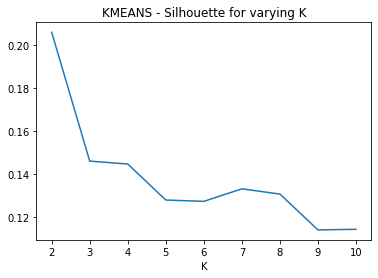

In [70]:
fig, ax = plt.subplots()
ax.plot(range(2, 11), silhouette_values)
ax.set_xticks(range(2, 11))
ax.set_title('KMEANS - Silhouette for varying K')
ax.set_xlabel('K')
plt.show()

We can do the same thing for the davies_bouldin_score for different K, always in the same range.

In [71]:
start_time = time.time()

davies_bouldin_values = []
for k in range(2, 11):
    kmeans_3 = KMeans(n_clusters=k).fit(df_clustering.drop(['class'], axis=1))
    davies_bouldin_values.append(davies_bouldin_score(df_clustering.drop(['class'], axis=1), kmeans_3.labels_))

elapsed_time_kmeans_2 = time.time() - start_time
print('elapsed time to train the models:',elapsed_time_kmeans_2)

elapsed time to train the models: 58.530372858047485


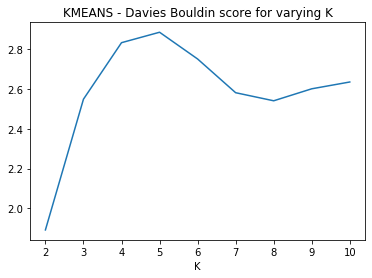

In [72]:
fig, ax = plt.subplots()
ax.plot(range(2, 11), davies_bouldin_values)
ax.set_xticks(range(2, 11))
ax.set_title('KMEANS - Davies Bouldin score for varying K')
ax.set_xlabel('K')
plt.show()

Homogeneity score for K range between 2 and 10.

In [73]:
homogeneity_values = []
for k in range(2, 11):
    kmeans_4 = KMeans(n_clusters=k).fit(df_clustering.drop(['class'], axis=1))
    homogeneity_values.append(homogeneity_score(df_clustering['class'].values, kmeans_4.labels_))

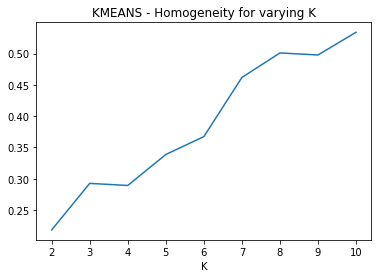

In [74]:
fig, ax = plt.subplots()
ax.plot(range(2, 11), homogeneity_values)
ax.set_xticks(range(2, 11))
ax.set_title('KMEANS - Homogeneity for varying K')
ax.set_xlabel('K')
plt.show()

Completeness score for K range between 2 and 10.

In [75]:
completeness_values = []
for k in range(2, 11):
    kmeans_5 = KMeans(n_clusters=k).fit(df_clustering.drop(['class'], axis=1))
    completeness_values.append(completeness_score(df_clustering['class'].values, kmeans_5.labels_))

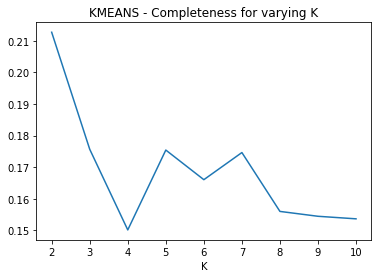

In [76]:
fig, ax = plt.subplots()
ax.plot(range(2, 11), completeness_values)
ax.set_xticks(range(2, 11))
ax.set_title('KMEANS - Completeness for varying K')
ax.set_xlabel('K')
plt.show()

V_measure for K in range between 2 and 10.

In [77]:
v_measure_values = []
for k in range(2, 11):
    kmeans_6 = KMeans(n_clusters=k).fit(df_clustering.drop(['class'], axis=1))
    v_measure_values.append(v_measure_score(df_clustering['class'].values, kmeans_6.labels_))

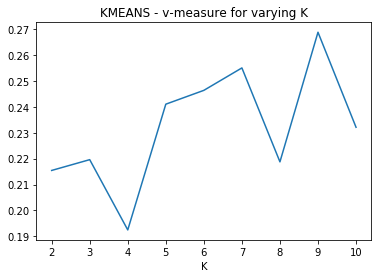

In [78]:
fig, ax = plt.subplots()
ax.plot(range(2, 11), v_measure_values)
ax.set_xticks(range(2, 11))
ax.set_title('KMEANS - v-measure for varying K')
ax.set_xlabel('K')
plt.show()

### 5.2. Hierarchical Clustering

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample. 

The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The algorithm is the following:

1. assign each data point to its own group 
2. merge 2 groups that are most similar
    - according to distance metrics
3. repeat <b>(2)</b> until only one group remains
4. *optional* select layer of tree giving "best" clustering results

Hierarchical clustering produces *dendogram* tree model that uses more storage space than k-means centroids, but that conveys more information about underlying structure of data.

In theory, hierarchical clustering works with *any kind of distance metric/similarity function* (k-means only with Euclidean), and work with *any kind of data* (k-means requires numerical data)

 - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering

For this clustering we are going to first drop the dummy column of the value "?" from our original "df_one_hot".

In [79]:
# df_clustering = df_one_hot.drop(['TelephonyManager.getSimCountryIso_?'], axis=1)

In [80]:
df_clustering_agglomerative = df_one_hot.drop(['TelephonyManager.getSimCountryIso_?'], axis=1)

In [81]:
# df_clustering_agglomerative.columns

Here we are fitting the Agglomerative Clustering algorithm on the new dataframe that we have created. Remember, we always drop the column "class" before training the algorithm.

In [82]:
start_time = time.time()

agglomerative = AgglomerativeClustering(n_clusters=6, affinity='euclidean',linkage='ward').fit(df_clustering_agglomerative.drop(('class'),axis=1))

elapsed_training_time_agglomerative = time.time() - start_time
print('elapsed time to train agglomerative clustering algorithm: ',elapsed_training_time_agglomerative)

elapsed time to train agglomerative clustering algorithm:  57.96488666534424


Here we retrieve some useful information from the algorithm:
- Number of leaves
- Labels of the elements of the dataframe
- Estimated number of connected components in the graph

In [83]:
agglomerative.n_leaves_

15036

In [84]:
agglomerative.labels_

array([3, 3, 3, ..., 4, 2, 2], dtype=int64)

In [85]:
agglomerative.n_connected_components_

1

Then, as we did before, we save the new labels in a new column of the dataframe that we are going to call "cluster".

In [86]:
df_clustering_agglomerative['cluster'] = agglomerative.labels_

#### 5.2.1. Evaluating the clustering algorithm

Using the same metrics that we used above we try to evaluate the correctness of the clustering.

In [87]:
df_clustering_agglomerative.groupby('cluster').size()

cluster
0    2675
1    2046
2    5141
3    2382
4    2163
5     629
dtype: int64

In [88]:
df_clustering_agglomerative.groupby('class').size()

class
B    9476
S    5560
dtype: int64

In [89]:
df_clustering_agglomerative.groupby(['cluster', 'class']).size().reset_index().sort_values(['class'])

,cluster,class,0
0,0,B,650
2,1,B,25
4,2,B,5032
6,3,B,1203
8,4,B,1939
10,5,B,627
1,0,S,2025
3,1,S,2021
5,2,S,109
7,3,S,1179


As we can see it is slightly better than the other clustering algorithm.
Now we print some score useful for the evaluation of the algorithm and after we will plot them for different K values, as we did before. The only difference is that this time the K range is between 2 and 10.

In [90]:
predicted_clusters_agglomerative = df_clustering_agglomerative['cluster'].values
true_labels_agglomerative = df_clustering_agglomerative['class'].values

In [91]:
homogeneity_score_agglomerative = homogeneity_score(true_labels_agglomerative, predicted_clusters_agglomerative)
completeness_score_agglomerative = completeness_score(true_labels_agglomerative, predicted_clusters_agglomerative)
v_measure_score_agglomerative = v_measure_score(true_labels_agglomerative, predicted_clusters_agglomerative)
silhouette_score_agglomerative = silhouette_score(df_clustering_agglomerative.drop(['class', 'cluster'], axis=1), agglomerative.labels_)
davies_bouldin_score_agglomerative = davies_bouldin_score(df_clustering_agglomerative.drop(['class', 'cluster'], axis=1), agglomerative.labels_)

In [92]:
print('homogeneity score:',homogeneity_score_agglomerative,'\n')
print('completeness score:',completeness_score_agglomerative,'\n')
print('v measure score:',v_measure_score_agglomerative,'\n')
print('silhouette score',silhouette_score_agglomerative,'\n')
print('davies bouldin score',davies_bouldin_score_agglomerative,'\n')

homogeneity score: 0.5426620322017952 

completeness score: 0.21680093245895457 

v measure score: 0.30982323053494576 

silhouette score 0.09886193195080295 

davies bouldin score 2.78009758793795 



Silhouette score:

In [93]:
start_time = time.time()

silhouette_values = []
for k in range(2, 11):
    agglomerative_2 = AgglomerativeClustering(n_clusters=k).fit(df_clustering.drop(['class'], axis=1))
    silhouette_values.append(silhouette_score(df_clustering.drop(['class'], axis=1), agglomerative_2.labels_))

elapsed_time_agglomerative_2 = time.time() - start_time
print('elapsed time to train the models:',elapsed_time_agglomerative_2)

elapsed time to train the models: 543.3550982475281


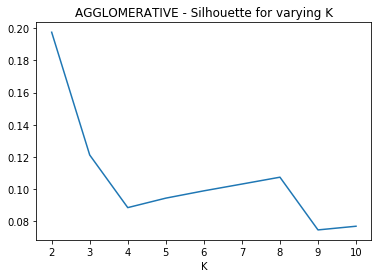

In [94]:
fig, ax = plt.subplots()
ax.plot(range(2, 11), silhouette_values)
ax.set_xticks(range(2, 11))
ax.set_title('AGGLOMERATIVE - Silhouette for varying K')
ax.set_xlabel('K')
plt.show()

V_measure score:

In [95]:
v_measure_values = []
for k in range(2, 11):
    agglomerative_3 = AgglomerativeClustering(n_clusters=k).fit(df_clustering.drop(['class'], axis=1))
    v_measure_values.append(v_measure_score(df_clustering['class'].values, agglomerative_3.labels_))

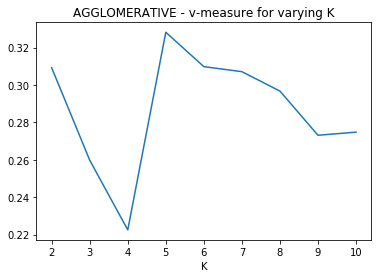

In [96]:
fig, ax = plt.subplots()
ax.plot(range(2, 11), v_measure_values)
ax.set_xticks(range(2, 11))
ax.set_title('AGGLOMERATIVE - v-measure for varying K')
ax.set_xlabel('K')
plt.show()

## 6. Mapping features to categories and re-classification using best hyperparameters combination

### 6.1. Mapping from features to categories

First thing that we have to do in this paragraph is to import some useful libraries

In [97]:
from collections import defaultdict
import csv

In [98]:
df.shape

(15036, 216)

In [99]:
category = defaultdict(list)

In [100]:
with open('../ASSIGNMENT/data/AndroidMalware/dataset-features-categories.csv','r') as csv_file:
    for line in csv_file:
        df_features, df_categories = line.strip().split(',')
        category[df_categories].append(df_features)
        
category_mapping = {v: k for k in category for v in category[k]}

In [101]:
category_mapping

{'transact': 'API call signature',
 'onServiceConnected': 'API call signature',
 'bindService': 'API call signature',
 'attachInterface': 'API call signature',
 'ServiceConnection': 'API call signature',
 'android.os.Binder': 'API call signature',
 'Ljava.lang.Class.getCanonicalName': 'API call signature',
 'Ljava.lang.Class.getMethods': 'API call signature',
 'Ljava.lang.Class.cast': 'API call signature',
 'Ljava.net.URLDecoder': 'API call signature',
 'android.content.pm.Signature': 'API call signature',
 'android.telephony.SmsManager': 'API call signature',
 'getBinder': 'API call signature',
 'ClassLoader': 'API call signature',
 'Landroid.content.Context.registerReceiver': 'API call signature',
 'Ljava.lang.Class.getField': 'API call signature',
 'Landroid.content.Context.unregisterReceiver': 'API call signature',
 'Ljava.lang.Class.getDeclaredField': 'API call signature',
 'getCallingUid': 'API call signature',
 'Ljavax.crypto.spec.SecretKeySpec': 'API call signature',
 'android.

In [102]:
len(set(category_mapping.values()))

5

In [103]:
type(category_mapping)

dict

Here we are going to create a new dataframe with the category that we have mapped above. This dataframe will be used to try again the classifiers for this dataset.

In [104]:
new_df = df.rename(mapper=category_mapping,axis=1)

Here we perform some operations on the columns of the new classifier.

In [105]:
new_df.columns

Index(['API call signature', 'API call signature', 'API call signature',
       'API call signature', 'API call signature', 'API call signature',
       'Manifest Permission', 'API call signature', 'API call signature',
       'API call signature',
       ...
       'Manifest Permission', 'Manifest Permission', 'Manifest Permission',
       'Manifest Permission', 'Manifest Permission', 'Manifest Permission',
       'Manifest Permission', 'Manifest Permission', 'Manifest Permission',
       'B=Benign; S=Malware'],
      dtype='object', length=216)

In [106]:
set(new_df.columns)

{'API call signature',
 'B=Benign; S=Malware',
 'Commands signature',
 'Intent',
 'Manifest Permission'}

In [107]:
new_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15036 entries, 0 to 15035
Data columns (total 216 columns):
API call signature     int64
API call signature     int64
API call signature     int64
API call signature     int64
API call signature     int64
API call signature     int64
Manifest Permission    int64
API call signature     int64
API call signature     int64
API call signature     int64
API call signature     int64
API call signature     int64
API call signature     int64
Manifest Permission    int64
API call signature     int64
API call signature     int64
API call signature     int64
API call signature     int64
API call signature     int64
Manifest Permission    int64
Manifest Permission    int64
API call signature     int64
Manifest Permission    int64
API call signature     int64
API call signature     int64
Intent                 int64
Manifest Permission    int64
Manifest Permission    int64
API call signature     int64
API call signature     int64
API call signature  

In [108]:
new_df.iloc[:,92]

0        0
1        0
2        0
3        0
4        0
        ..
15031    1
15032    0
15033    0
15034    0
15035    1
Name: API call signature, Length: 15036, dtype: object

### 6.2. New test of the classifiers

Now, we can create again the dummy variables for the dataframe with the mapped categories. Before getting dummies we are dropping the columns that contain the classification, Benign and Malware.

In [109]:
new_df_dummy = pd.get_dummies(new_df.drop('B=Benign; S=Malware',axis=1))

In [110]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15036 entries, 0 to 15035
Columns: 216 entries, API call signature to B=Benign; S=Malware
dtypes: int64(214), object(2)
memory usage: 24.8+ MB


In [111]:
new_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15036 entries, 0 to 15035
Columns: 217 entries, API call signature to API call signature_?
dtypes: int64(214), uint8(3)
memory usage: 24.6 MB


As we did before we are splitting the dataframe into train and test variables, the train variables will be 70% of the dataframe and test ones will be the remaining 30%.

In [112]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(
    new_df_dummy, 
    new_df['B=Benign; S=Malware'], 
    test_size=0.3)

In [113]:
# new_X_train.columns

<b> NB. For all the classifier that we are going to use now we are using the best hyperparameter that we have found before. </b>

#### 6.2.1. Decision Tree

Training and Prediction:

In [114]:
start_time = time.time()
#print(time.time())

clf_newDT = DecisionTreeClassifier(criterion='entropy',max_depth=300,max_leaf_nodes=300,splitter='best').fit(new_X_train.drop(new_X_train.columns[-1],axis=1), new_y_train)

elapsed_training_time_newDT = time.time() - start_time
print("Elapsed time to fit the model: %.2f seconds" % elapsed_training_time_newDT,'\n')

start_time = time.time()

y_pred_newDT = clf_newDT.predict(new_X_test.drop(new_X_test.columns[-1],axis=1))

elapsed_prediction_time_newDT = time.time() - start_time
print("Elapsed time to make the predictions: %.2f seconds" % elapsed_prediction_time_newDT,'\n')

Elapsed time to fit the model: 0.50 seconds 

Elapsed time to make the predictions: 0.06 seconds 



Creating variables for metrics:

In [115]:
accuracy_score_newDT = accuracy_score(new_y_test,y_pred_newDT)

classification_report_newDT = classification_report(new_y_test,y_pred_newDT,digits=5)

balanced_accuracy_score_newDT = balanced_accuracy_score(new_y_test,y_pred_newDT)

confusion_matrix_true_newDT = confusion_matrix(new_y_test, new_y_test)   

confusion_matrix_pred_newDT = confusion_matrix(new_y_test,y_pred_newDT)

Here we are searching for the first 15 features in order of importance.

In [116]:
sort_importances = np.argsort(clf_newDT.feature_importances_)
top_15_features_newDT = sort_importances[0:15]

In [117]:
top_15_features_newDT

array([107,  86,  85, 148,  83, 149,  81,  80, 150, 155, 156, 157, 158,
        71,  70], dtype=int64)

In [118]:
new_X_train.columns[top_15_features_newDT]

Index(['Manifest Permission', 'API call signature', 'API call signature',
       'Commands signature', 'API call signature', 'Intent', 'Intent',
       'API call signature', 'Manifest Permission', 'API call signature',
       'Intent', 'API call signature', 'Manifest Permission',
       'Manifest Permission', 'API call signature'],
      dtype='object')

#### 6.2.2. Random Forest

Training and Prediction:

In [119]:
start_time = time.time()
#print(time.time())

clf_newRF = RandomForestClassifier(criterion='gini',verbose=1,warm_start=True,max_depth=340,max_leaf_nodes=None,n_estimators=200).fit(new_X_train.drop(new_X_train.columns[-1],axis=1), new_y_train)

elapsed_training_time_newRF = time.time() - start_time
print("Elapsed time to fit the model: %.2f seconds" % elapsed_training_time_newRF,'\n')

start_time = time.time()

y_pred_newRF = clf_newRF.predict(new_X_test.drop(new_X_test.columns[-1],axis=1))

elapsed_prediction_time_newRF = time.time() - start_time
print("Elapsed time to make the predictions: %.2f seconds" % elapsed_prediction_time_newRF,'\n')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Elapsed time to fit the model: 3.55 seconds 

Elapsed time to make the predictions: 0.21 seconds 



[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


Saving variables of various metrics:

In [120]:
accuracy_score_newRF = accuracy_score(new_y_test,y_pred_newRF)

classification_report_newRF = classification_report(new_y_test,y_pred_newRF,digits=5)

balanced_accuracy_score_newRF = balanced_accuracy_score(new_y_test,y_pred_newRF)

confusion_matrix_true_newRF = confusion_matrix(new_y_test, new_y_test)   

confusion_matrix_pred_newRF = confusion_matrix(new_y_test,y_pred_newRF)

Checking the first features in order of importance:

In [121]:
sort_importances = np.argsort(clf_newRF.feature_importances_)
top_15_features_newRF = sort_importances[0:15]

In [122]:
top_15_features_newRF

array([197, 141, 155, 157, 184, 135, 164, 123, 175, 189, 181, 159, 119,
       163, 118], dtype=int64)

In [123]:
new_X_train.columns[top_15_features_newRF]

Index(['Manifest Permission', 'API call signature', 'API call signature',
       'API call signature', 'Intent', 'Manifest Permission',
       'Manifest Permission', 'Manifest Permission', 'Manifest Permission',
       'API call signature', 'Manifest Permission', 'Manifest Permission',
       'Manifest Permission', 'Manifest Permission', 'Manifest Permission'],
      dtype='object')

#### 6.2.3. Multi-layer Perceptron

Training and Prediction:

In [124]:
start_time = time.time()
#print(time.time())

clf_newMLP = MLPClassifier(hidden_layer_sizes=(300, ), activation='relu', solver='adam',learning_rate='adaptive',verbose=True,tol=0.000001)

clf_newMLP.fit(new_X_train.drop(new_X_train.columns[-1],axis=1), new_y_train)

elapsed_training_time_newMLP = time.time() - start_time
print("Elapsed time to fit the model: %.2f seconds" % elapsed_training_time_newMLP,'\n')

start_time = time.time()

y_pred_newMLP = clf_newMLP.predict(new_X_test.drop(new_X_test.columns[-1],axis=1))

elapsed_prediction_time_newMLP = time.time() - start_time
print("Elapsed time to make the prediction: %.2f seconds" % elapsed_prediction_time_newMLP,'\n')

Iteration 1, loss = 0.26927297
Iteration 2, loss = 0.10720428
Iteration 3, loss = 0.07937824
Iteration 4, loss = 0.06580859
Iteration 5, loss = 0.05802360
Iteration 6, loss = 0.05215589
Iteration 7, loss = 0.04747829
Iteration 8, loss = 0.04348308
Iteration 9, loss = 0.04002466
Iteration 10, loss = 0.03751047
Iteration 11, loss = 0.03411787
Iteration 12, loss = 0.03152785
Iteration 13, loss = 0.02927961
Iteration 14, loss = 0.02705395
Iteration 15, loss = 0.02546214
Iteration 16, loss = 0.02323063
Iteration 17, loss = 0.02184715
Iteration 18, loss = 0.02014755
Iteration 19, loss = 0.01924194
Iteration 20, loss = 0.01798139
Iteration 21, loss = 0.01675157
Iteration 22, loss = 0.01620023
Iteration 23, loss = 0.01479533
Iteration 24, loss = 0.01358071
Iteration 25, loss = 0.01297558
Iteration 26, loss = 0.01228664
Iteration 27, loss = 0.01165645
Iteration 28, loss = 0.01093019
Iteration 29, loss = 0.01030411
Iteration 30, loss = 0.00994618
Iteration 31, loss = 0.00941299
Iteration 32, los

Saving metrics into variables:

In [125]:
accuracy_score_newMLP = accuracy_score(new_y_test,y_pred_newMLP)

classification_report_newMLP = classification_report(new_y_test,y_pred_newMLP,digits=5)

balanced_accuracy_score_newMLP = balanced_accuracy_score(new_y_test,y_pred_newMLP)

confusion_matrix_true_newMLP = confusion_matrix(new_y_test, new_y_test)   

confusion_matrix_pred_newMLP = confusion_matrix(new_y_test,y_pred_newMLP)

In [126]:
new_X_train.columns

Index(['API call signature', 'API call signature', 'API call signature',
       'API call signature', 'API call signature', 'API call signature',
       'Manifest Permission', 'API call signature', 'API call signature',
       'API call signature',
       ...
       'Manifest Permission', 'Manifest Permission', 'Manifest Permission',
       'Manifest Permission', 'Manifest Permission', 'Manifest Permission',
       'Manifest Permission', 'API call signature_0', 'API call signature_1',
       'API call signature_?'],
      dtype='object', length=217)

In [127]:
new_y_train.shape

(10525,)

#### 6.2.4. C-Support Vector Classification

Training and Prediction:

In [128]:
start_time = time.time()
#print(time.time())

clf_newSVC = SVC(verbose=1,kernel='rbf',gamma='scale',decision_function_shape='ovo')

clf_newSVC.fit(new_X_train.drop(new_X_train.columns[-1],axis=1), new_y_train)

elapsed_training_time_newSVC = time.time() - start_time
print("Elapsed time to fit the model: %.2f seconds" % elapsed_training_time_newSVC,'\n')

start_time = time.time()

y_pred_newSVC = clf_newSVC.predict(new_X_test.drop(new_X_train.columns[-1],axis=1))

elapsed_prediction_time_newSVC = time.time() - start_time
print("Elapsed time to make the prediction: %.2f seconds" % elapsed_prediction_time_newSVC,'\n')

[LibSVM]Elapsed time to fit the model: 5.67 seconds 

Elapsed time to make the prediction: 1.67 seconds 



Saving into variables useful metrics for evaluation:

In [129]:
accuracy_score_newSVC = accuracy_score(new_y_test,y_pred_newSVC)

classification_report_newSVC = classification_report(new_y_test,y_pred_newSVC,digits=5)

balanced_accuracy_score_newSVC = balanced_accuracy_score(new_y_test,y_pred_newSVC)

confusion_matrix_true_newSVC = confusion_matrix(new_y_test, new_y_test)   

confusion_matrix_pred_newSVC = confusion_matrix(new_y_test,y_pred_newSVC)

### 6.3. Merging columns before training

<b> NB. This revealed to be not a good solutions because all the classifiers performed worse when we tried this </b>

In [130]:
# new_df_dummy.columns

Here we perform the merging, grouping the column and then creating a new dataframe called "merged" data.

In [131]:
merged_df = new_df_dummy.groupby(new_df_dummy.columns, axis=1).sum()

In [132]:
merged_data = pd.DataFrame(merged_df)

Here we are checking the shape of the new dataframe and comparing them with the shape of the class columns.

In [133]:
merged_data.shape

(15036, 7)

In [134]:
new_df['B=Benign; S=Malware'].shape

(15036,)

Now we have to create the new train and test with the merged columns, the size remain always the same (70% for training and 30% for testing).

In [135]:
merged_X_train, merged_X_test, merged_y_train, merged_y_test = train_test_split(
    merged_data.drop('API call signature_?',axis=1), 
    new_df['B=Benign; S=Malware'], 
    test_size=0.3)

In [136]:
# new_X_train.columns

<b> NB. Also with this classifiers we are going to use the best combination of hyperparameters that we have found above. </b>

#### 6.3.1. DecisionTree

Training and Prediction:

In [137]:
start_time = time.time()
#print(time.time())

clf_mergedDT = DecisionTreeClassifier(criterion='entropy',max_depth=300,max_leaf_nodes=300,splitter='best').fit(merged_X_train, merged_y_train)

elapsed_training_time_mergedDT = time.time() - start_time
print("Elapsed time to fit the model: %.2f seconds" % elapsed_training_time_mergedDT,'\n')

start_time = time.time()

y_pred_mergedDT = clf_mergedDT.predict(merged_X_test)

elapsed_prediction_time_mergedDT = time.time() - start_time
print("Elapsed time to make the predictions: %.2f seconds" % elapsed_prediction_time_mergedDT,'\n')

Elapsed time to fit the model: 0.03 seconds 

Elapsed time to make the predictions: 0.00 seconds 



Saving variables of metrics:

In [138]:
accuracy_score_mergedDT = accuracy_score(merged_y_test,y_pred_mergedDT)

classification_report_mergedDT = classification_report(merged_y_test,y_pred_mergedDT,digits=5)

balanced_accuracy_score_mergedDT = balanced_accuracy_score(merged_y_test,y_pred_mergedDT)

confusion_matrix_true_mergedDT = confusion_matrix(merged_y_test, merged_y_test)   

confusion_matrix_pred_mergedDT = confusion_matrix(merged_y_test,y_pred_mergedDT)

In [139]:
print(classification_report_mergedDT)

              precision    recall  f1-score   support

           B    0.90776   0.94709   0.92701      2816
           S    0.90528   0.84012   0.87148      1695

    accuracy                        0.90689      4511
   macro avg    0.90652   0.89360   0.89924      4511
weighted avg    0.90683   0.90689   0.90614      4511



#### 6.3.2. Random Forest

Training and Prediction:

In [140]:
start_time = time.time()
#print(time.time())

clf_mergedRF = RandomForestClassifier(criterion='gini',verbose=1,warm_start=True,max_depth=340,max_leaf_nodes=None,n_estimators=200).fit(merged_X_train, merged_y_train)

elapsed_training_time_mergedRF = time.time() - start_time
print("Elapsed time to fit the model: %.2f seconds" % elapsed_training_time_mergedRF,'\n')

start_time = time.time()

y_pred_mergedRF = clf_mergedRF.predict(merged_X_test)

elapsed_prediction_time_mergedRF = time.time() - start_time
print("Elapsed time to make the predictions: %.2f seconds" % elapsed_prediction_time_mergedRF,'\n')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Elapsed time to fit the model: 1.33 seconds 

Elapsed time to make the predictions: 0.16 seconds 



[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


Saving variables of metrics:

In [141]:
accuracy_score_mergedRF = accuracy_score(merged_y_test,y_pred_mergedRF)

classification_report_mergedRF = classification_report(merged_y_test,y_pred_mergedRF,digits=5)

balanced_accuracy_score_mergedRF = balanced_accuracy_score(merged_y_test,y_pred_mergedRF)

confusion_matrix_true_mergedRF = confusion_matrix(merged_y_test, merged_y_test)   

confusion_matrix_pred_mergedRF = confusion_matrix(merged_y_test,y_pred_mergedRF)

In [142]:
print(classification_report_mergedRF)

              precision    recall  f1-score   support

           B    0.92695   0.94176   0.93430      2816
           S    0.90061   0.87670   0.88849      1695

    accuracy                        0.91731      4511
   macro avg    0.91378   0.90923   0.91139      4511
weighted avg    0.91705   0.91731   0.91708      4511



#### 6.3.3. Multi-layer Perceptron

Training and Prediction:

In [143]:
start_time = time.time()
#print(time.time())

clf_mergedMLP = MLPClassifier(hidden_layer_sizes=(300, ), activation='relu', solver='adam',learning_rate='adaptive',verbose=True,tol=0.000001)

clf_mergedMLP.fit(merged_X_train, merged_y_train)

elapsed_training_time_mergedMLP = time.time() - start_time
print("Elapsed time to fit the model: %.2f seconds" % elapsed_training_time_mergedMLP,'\n')

start_time = time.time()

y_pred_mergedMLP = clf_mergedMLP.predict(merged_X_test)

elapsed_prediction_time_mergedMLP = time.time() - start_time
print("Elapsed time to make the prediction: %.2f seconds" % elapsed_prediction_time_mergedMLP,'\n')

Iteration 1, loss = 0.58523826
Iteration 2, loss = 0.45471491
Iteration 3, loss = 0.41612381
Iteration 4, loss = 0.39184121
Iteration 5, loss = 0.37465838
Iteration 6, loss = 0.36060125
Iteration 7, loss = 0.35141289
Iteration 8, loss = 0.34394462
Iteration 9, loss = 0.34078807
Iteration 10, loss = 0.33386720
Iteration 11, loss = 0.33068018
Iteration 12, loss = 0.32641365
Iteration 13, loss = 0.32479327
Iteration 14, loss = 0.32326239
Iteration 15, loss = 0.32198624
Iteration 16, loss = 0.31840381
Iteration 17, loss = 0.31838220
Iteration 18, loss = 0.31901001
Iteration 19, loss = 0.31420558
Iteration 20, loss = 0.31194420
Iteration 21, loss = 0.31442975
Iteration 22, loss = 0.31046751
Iteration 23, loss = 0.30973343
Iteration 24, loss = 0.30836589
Iteration 25, loss = 0.30965179
Iteration 26, loss = 0.30852552
Iteration 27, loss = 0.30608716
Iteration 28, loss = 0.30521647
Iteration 29, loss = 0.30602496
Iteration 30, loss = 0.30535060
Iteration 31, loss = 0.30667558
Iteration 32, los

Saving variables of metrics:

In [144]:
accuracy_score_mergedMLP = accuracy_score(merged_y_test,y_pred_mergedMLP)

classification_report_mergedMLP = classification_report(merged_y_test,y_pred_mergedMLP,digits=5)

balanced_accuracy_score_mergedMLP = balanced_accuracy_score(merged_y_test,y_pred_mergedMLP)

confusion_matrix_true_mergedMLP = confusion_matrix(merged_y_test, merged_y_test)   

confusion_matrix_pred_mergedMLP = confusion_matrix(merged_y_test,y_pred_mergedMLP)

In [145]:
print(classification_report_mergedMLP)

              precision    recall  f1-score   support

           B    0.90220   0.90412   0.90316      2816
           S    0.84014   0.83717   0.83865      1695

    accuracy                        0.87896      4511
   macro avg    0.87117   0.87064   0.87090      4511
weighted avg    0.87888   0.87896   0.87892      4511



#### 6.3.4. C-Support Vector Classification

Training and Prediction:

In [146]:
start_time = time.time()
#print(time.time())

clf_mergedSVC = SVC(verbose=1,kernel='rbf',gamma='scale',decision_function_shape='ovo')

clf_mergedSVC.fit(merged_X_train, merged_y_train)

elapsed_training_time_mergedSVC = time.time() - start_time
print("Elapsed time to fit the model: %.2f seconds" % elapsed_training_time_mergedSVC,'\n')

start_time = time.time()

y_pred_mergedSVC = clf_mergedSVC.predict(merged_X_test)

elapsed_prediction_time_mergedSVC = time.time() - start_time
print("Elapsed time to make the prediction: %.2f seconds" % elapsed_prediction_time_mergedSVC,'\n')

[LibSVM]Elapsed time to fit the model: 2.00 seconds 

Elapsed time to make the prediction: 0.44 seconds 



Saving variables of metrics:

In [147]:
accuracy_score_mergedSVC = accuracy_score(merged_y_test,y_pred_mergedSVC)

classification_report_mergedSVC = classification_report(merged_y_test,y_pred_mergedSVC,digits=5)

balanced_accuracy_score_mergedSVC = balanced_accuracy_score(merged_y_test,y_pred_mergedSVC)

confusion_matrix_true_mergedSVC = confusion_matrix(merged_y_test, merged_y_test)   

confusion_matrix_pred_mergedSVC = confusion_matrix(merged_y_test,y_pred_mergedSVC)

In [148]:
print(classification_report_mergedSVC)

              precision    recall  f1-score   support

           B    0.88355   0.84872   0.86579      2816
           S    0.76412   0.81416   0.78835      1695

    accuracy                        0.83573      4511
   macro avg    0.82383   0.83144   0.82707      4511
weighted avg    0.83867   0.83573   0.83669      4511



## 7. Final Results

In this paragraph we are resuming all the results that the classifiers got but this time we mapped all the features into 10 categoreis and using the best combination of hyperparameters we can evaluate again the performances of the classifiers. This time we will look only for the top 15 features.

In [149]:
print('\n---------------------------------------------------------------------------------------------------------------------------\n')

print('DECISION TREE:\n')

print('new_DecisionTreeClassifier interesting metrics:\n')

print('elapsed time for training:',elapsed_training_time_newDT,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_newDT,'\n')

print('classification_report: \n', classification_report_newDT,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_newDT,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_newDT,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_newDT,'\n')

print('top 15 features for importance:\n',new_X_train.columns[top_15_features_newDT])

print('\n---------------------------------------------------------------------------------------------------------------------------\n')

print('RANDOM FOREST CLASSIFIER:\n')

print('new_RandomForestClassifier interesting metrics:\n')

print('elapsed time for training:',elapsed_training_time_newRF,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_newRF,'\n') 

print('classification_report: \n', classification_report_newRF,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_newRF,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_newRF,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_newRF,'\n')

print('top 15 features for importance:\n',new_X_train.columns[top_15_features_newRF])

print('\n---------------------------------------------------------------------------------------------------------------------------\n')

print('MULTI-LAYER PERCEPTRON CLASSIFIER:\n')

print('new_Multi-layerPerceptronClassifier interesting metrics:\n')

print('elapsed time for training:',elapsed_training_time_newMLP,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_newMLP,'\n')

print('classification_report: \n', classification_report_newMLP,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_newMLP,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_newMLP,'\n')
print('confusion_matrix-pred value: \n',confusion_matrix_pred_newMLP,'\n')

print('\n---------------------------------------------------------------------------------------------------------------------------\n')

print('C-SUPPORT VECTOR CLASSIFIER:\n')

print('new_C-SupportVectorClassifier interesting metrics:\n')

print('elapsed time for training:',elapsed_training_time_newSVC,'\n')
print('elapsed time to make predictions:', elapsed_prediction_time_newSVC,'\n')

print('classification_report: \n', classification_report_newSVC,'\n')
print('balanced_accuracy_score:', balanced_accuracy_score_newSVC,'\n')

print('confusion_matrix-true value: \n',confusion_matrix_true_newSVC,'\n')
print('cconfusion_matrix-pred value: \n',confusion_matrix_pred_newSVC,'\n')

print('\n---------------------------------------------------------------------------------------------------------------------------\n')



---------------------------------------------------------------------------------------------------------------------------

DECISION TREE:

new_DecisionTreeClassifier interesting metrics:

elapsed time for training: 0.5000817775726318 

elapsed time to make predictions: 0.05534815788269043 

classification_report: 
               precision    recall  f1-score   support

           B    0.98417   0.97456   0.97934      2870
           S    0.95626   0.97258   0.96435      1641

    accuracy                        0.97384      4511
   macro avg    0.97021   0.97357   0.97185      4511
weighted avg    0.97401   0.97384   0.97389      4511
 

balanced_accuracy_score: 0.9735710782284109 

confusion_matrix-true value: 
 [[2870    0]
 [   0 1641]] 

confusion_matrix-pred value: 
 [[2797   73]
 [  45 1596]] 

top 15 features for importance:
 Index(['Manifest Permission', 'API call signature', 'API call signature',
       'Commands signature', 'API call signature', 'Intent', 'Intent',
       

We can conclude, after the training and the test phases, that the best tryed classifier is Multi-Layer Perceptron, followed by Random Forest Classifier. 
Again we gave to the "Balanced Accuracy Score" and to the confusion matrix more importance than to the other metrics because we were interested to the recall values of the two predicted classes. 
So, MLP had a balanced accuracy score equal to 98.718% and RF equal to 98.489%. MLP predicted 25 apps as malicious instead of bening, and 28 as bening instead of malicious. RF predicted only 14 apps as malicious instead of bening but 42 as bening instead of malicious. 

###### @falble

###### @gussr

###### @FiloLafro